# Session 4 — Paragraph-Level Analysis
## Measure 1: Paragraph Semantic Coherence

In this notebook, you will:
- split your text into paragraphs and sentences
- compute **embedding-based coherence** per paragraph using MiniLM
- compare coherence distributions across two books
- connect this to how RAG systems and LLMs assess chunk quality

We again use Lewis Carroll's *Alice* books as examples. Replace the file
paths with your own author/text for your project.


In [32]:
import re
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import gc

# You may need to install this once in your environment:
# pip install sentence-transformers
from sentence_transformers import SentenceTransformer

# Create results directory
Path("../results").mkdir(exist_ok=True)
print("✓ Results directory created/verified")

# Load the MiniLM embedding model
# This model converts text into numerical vectors (embeddings)
# that capture semantic meaning
print("Loading embedding model (this may take a moment)...")
model = SentenceTransformer('all-MiniLM-L6-v2')
print("✓ Model loaded successfully")

def load_book(filepath: str) -> str:
    """
    Load and lightly clean a book text (Project Gutenberg style).

    Removes headers and footers to get clean text for analysis.

    Args:
        filepath: path to the text file

    Returns:
        Cleaned text as string
    """
    with open(filepath, 'r', encoding='utf-8') as f:
        text = f.read()

    # Simple Project Gutenberg cleaner
    # Look for common start markers
    if 'BOOK I' in text:
        start = text.find('BOOK I')
        text = text[start:]
    elif 'CHAPTER I' in text:
        start = text.find('CHAPTER I')
        text = text[start:]
    elif '*** START OF' in text:
        start = text.find('*** START OF')
        text = text[start + 100:]

    # Look for common end markers
    if '*** END OF' in text:
        end = text.find('*** END OF')
        text = text[:end]
    elif 'End of Project Gutenberg' in text:
        end = text.find('End of Project Gutenberg')
        text = text[:end]

    return text.strip()

# Load both Homer epics
print("\nLoading texts...")
iliad_text = load_book('../data/iliad.txt')
odyssey_text = load_book('../data/odyssey.txt')

print(f"✓ The Iliad: {len(iliad_text):,} characters")
print(f"✓ The Odyssey: {len(odyssey_text):,} characters")

✓ Results directory created/verified
Loading embedding model (this may take a moment)...
✓ Model loaded successfully

Loading texts...
✓ The Iliad: 807,189 characters
✓ The Odyssey: 610,258 characters


In [33]:
def split_into_paragraphs(text: str, min_words: int = 10) -> List[str]:
    """
    Split raw text into paragraphs using blank lines as boundaries.

    In books, paragraphs are separated by blank lines (double newlines).
    We filter out very short paragraphs like chapter titles.

    Args:
        text: the complete text
        min_words: minimum words required to count as a paragraph

    Returns:
        List of paragraph strings
    """
    # Normalize line endings
    text = text.replace('\r\n', '\n').replace('\r', '\n')

    # Split on blank lines (one or more empty lines)
    raw_paras = re.split(r'\n\s*\n+', text)

    paras = []
    for p in raw_paras:
        # Clean up whitespace
        cleaned = re.sub(r'\s+', ' ', p).strip()
        if not cleaned:
            continue
        # Filter out short paragraphs (likely titles or artifacts)
        if len(cleaned.split()) < min_words:
            continue
        paras.append(cleaned)

    return paras

def sentence_split(paragraph: str) -> List[str]:
    """
    Simple sentence splitter based on punctuation.

    Splits on periods, exclamation marks, and question marks.

    Args:
        paragraph: text to split

    Returns:
        List of sentences
    """
    sentences = re.split(r'[.!?]+\s+', paragraph.strip())
    sentences = [s.strip() for s in sentences if s.strip()]
    return sentences

def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    """
    Calculate cosine similarity between two vectors.

    Cosine similarity measures how similar two vectors are:
    - 1.0 = identical direction (very similar)
    - 0.0 = perpendicular (unrelated)
    - -1.0 = opposite direction (very dissimilar)

    Args:
        a, b: embedding vectors

    Returns:
        Similarity score between 0 and 1
    """
    if a.ndim > 1:
        a = a.reshape(-1)
    if b.ndim > 1:
        b = b.reshape(-1)
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    if denom == 0:
        return 0.0
    return float(np.dot(a, b) / denom)

def paragraph_coherence_embeddings(paragraphs: List[str]) -> Tuple[list, list]:
    """
    Compute embedding-based coherence for each paragraph.

    HOW IT WORKS:
    1. Split each paragraph into sentences
    2. Convert each sentence to an embedding (semantic vector)
    3. Calculate the centroid (average) of all sentence embeddings
    4. Coherence = average similarity of each sentence to the centroid

    HIGH COHERENCE: All sentences are semantically similar (stick to topic)
    LOW COHERENCE: Sentences are semantically diverse (jump between topics)

    Args:
        paragraphs: list of paragraph texts

    Returns:
        Tuple of (coherence_scores, paragraph_lengths)
    """
    scores = []
    lengths = []

    print(f"Analyzing {len(paragraphs)} paragraphs...")

    for i, p in enumerate(paragraphs):
        if (i + 1) % 100 == 0:
            print(f"  Processed {i + 1}/{len(paragraphs)} paragraphs...")

        sents = sentence_split(p)
        # Need at least 2 sentences to measure coherence
        if len(sents) < 2:
            continue

        # Encode all sentences in this paragraph into embeddings
        sent_embs = model.encode(sents)

        # Calculate centroid (mean embedding) - represents the paragraph's "topic"
        centroid = sent_embs.mean(axis=0)

        # Measure how similar each sentence is to the centroid
        sims = [cosine_similarity(e, centroid) for e in sent_embs]

        # Average similarity = coherence score
        scores.append(sum(sims) / len(sims))
        lengths.append(len(" ".join(sents).split()))

    print(f"✓ Analysis complete")
    return scores, lengths

# Split texts into paragraphs
print("\nSplitting texts into paragraphs...")
iliad_paras = split_into_paragraphs(iliad_text)
odyssey_paras = split_into_paragraphs(odyssey_text)

print(f"✓ The Iliad: {len(iliad_paras)} paragraphs")
print(f"✓ The Odyssey: {len(odyssey_paras)} paragraphs")

# Calculate coherence scores for each paragraph
print("\nCalculating coherence scores for The Iliad...")
iliad_scores, iliad_lengths = paragraph_coherence_embeddings(iliad_paras)

print("\nCalculating coherence scores for The Odyssey...")
odyssey_scores, odyssey_lengths = paragraph_coherence_embeddings(odyssey_paras)

# Print summary statistics
print("\n" + "="*70)
print("COHERENCE SUMMARY")
print("="*70)
print(f"The Iliad mean coherence: {sum(iliad_scores)/len(iliad_scores):.3f}")
print(f"The Odyssey mean coherence: {sum(odyssey_scores)/len(odyssey_scores):.3f}")
print(f"\nInterpretation:")
print(f"  Higher score = paragraphs stick to one topic")
print(f"  Lower score = paragraphs cover multiple topics")



Splitting texts into paragraphs...
✓ The Iliad: 1114 paragraphs
✓ The Odyssey: 1027 paragraphs

Calculating coherence scores for The Iliad...
Analyzing 1114 paragraphs...
  Processed 100/1114 paragraphs...
  Processed 200/1114 paragraphs...
  Processed 300/1114 paragraphs...
  Processed 400/1114 paragraphs...
  Processed 500/1114 paragraphs...
  Processed 600/1114 paragraphs...
  Processed 700/1114 paragraphs...
  Processed 800/1114 paragraphs...
  Processed 900/1114 paragraphs...
  Processed 1000/1114 paragraphs...
  Processed 1100/1114 paragraphs...
✓ Analysis complete

Calculating coherence scores for The Odyssey...
Analyzing 1027 paragraphs...
  Processed 100/1027 paragraphs...
  Processed 200/1027 paragraphs...
  Processed 300/1027 paragraphs...
  Processed 400/1027 paragraphs...
  Processed 500/1027 paragraphs...
  Processed 600/1027 paragraphs...
  Processed 700/1027 paragraphs...
  Processed 800/1027 paragraphs...
  Processed 900/1027 paragraphs...
  Processed 1000/1027 paragr


✓ Saved: ../results/paragraph_coherence_vs_length.png


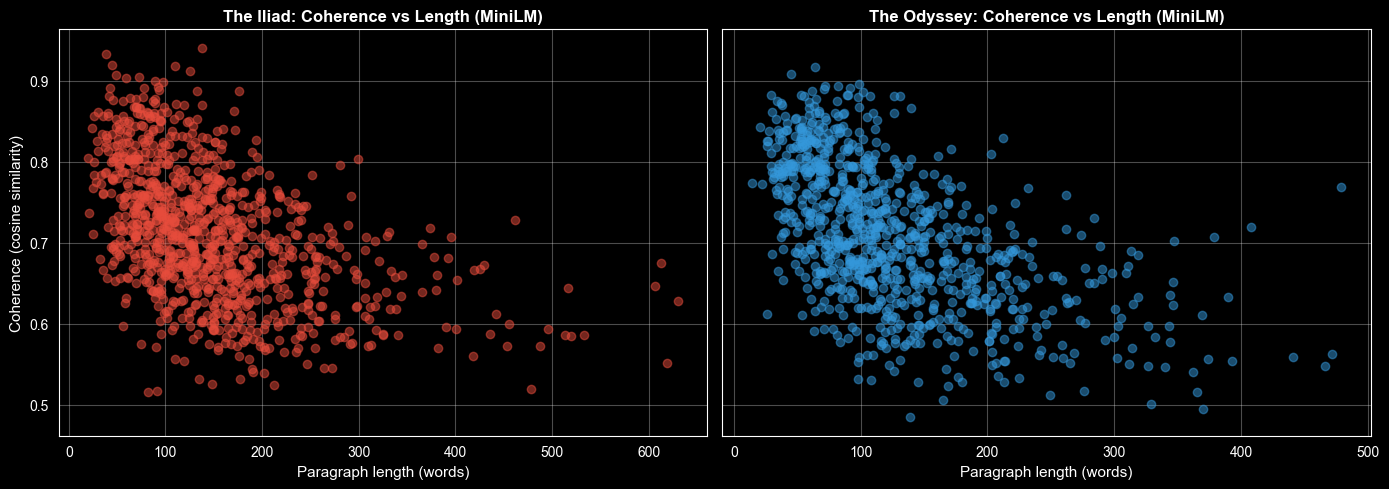

In [34]:
# Create scatter plots showing relationship between length and coherence
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# The Iliad
axes[0].scatter(iliad_lengths, iliad_scores, alpha=0.5, color='#e74c3c')
axes[0].set_title("The Iliad: Coherence vs Length (MiniLM)",
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel("Paragraph length (words)", fontsize=11)
axes[0].set_ylabel("Coherence (cosine similarity)", fontsize=11)
axes[0].grid(True, alpha=0.3)

# The Odyssey
axes[1].scatter(odyssey_lengths, odyssey_scores, alpha=0.5, color='#3498db')
axes[1].set_title("The Odyssey: Coherence vs Length (MiniLM)",
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel("Paragraph length (words)", fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("../results/paragraph_coherence_vs_length.png", dpi=300, bbox_inches='tight')
print("\n✓ Saved: ../results/paragraph_coherence_vs_length.png")
plt.show()

✓ Saved: ../results/paragraph_coherence_distribution.png


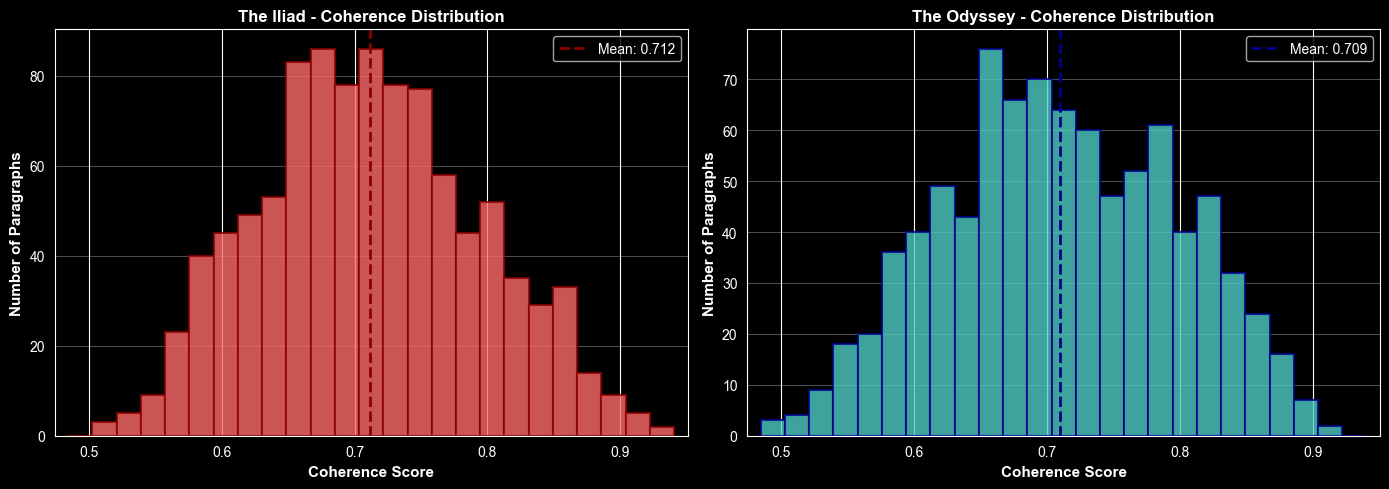

In [35]:
# Create side-by-side histograms for clearer comparison
# Set same x-axis range for fair comparison
all_scores = iliad_scores + odyssey_scores
min_score = min(all_scores)
max_score = max(all_scores)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# The Iliad histogram
axes[0].hist(iliad_scores, bins=25, alpha=0.8,
             edgecolor='darkred', linewidth=1.5, color='#ff6b6b',
             range=(min_score, max_score))
axes[0].axvline(np.mean(iliad_scores), color='darkred',
                linestyle='--', linewidth=2, label=f'Mean: {np.mean(iliad_scores):.3f}')
axes[0].set_xlabel('Coherence Score', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Number of Paragraphs', fontsize=11, fontweight='bold')
axes[0].set_title('The Iliad - Coherence Distribution',
                  fontsize=12, fontweight='bold')
axes[0].set_xlim(min_score - 0.01, max_score + 0.01)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# The Odyssey histogram
axes[1].hist(odyssey_scores, bins=25, alpha=0.8,
             edgecolor='darkblue', linewidth=1.5, color='#4ecdc4',
             range=(min_score, max_score))
axes[1].axvline(np.mean(odyssey_scores), color='darkblue',
                linestyle='--', linewidth=2, label=f'Mean: {np.mean(odyssey_scores):.3f}')
axes[1].set_xlabel('Coherence Score', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Number of Paragraphs', fontsize=11, fontweight='bold')
axes[1].set_title('The Odyssey - Coherence Distribution',
                  fontsize=12, fontweight='bold')
axes[1].set_xlim(min_score - 0.01, max_score + 0.01)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig("../results/paragraph_coherence_distribution.png", dpi=300, bbox_inches='tight')
print("✓ Saved: ../results/paragraph_coherence_distribution.png")
plt.show()

In [36]:
print("\n" + "="*70)
print("DETAILED STATISTICS")
print("="*70)
print(f"\nThe Iliad:")
print(f"  Paragraphs analyzed: {len(iliad_scores)}")
print(f"  Mean coherence: {np.mean(iliad_scores):.3f}")
print(f"  Std deviation: {np.std(iliad_scores):.3f}")
print(f"  Min coherence: {np.min(iliad_scores):.3f}")
print(f"  Max coherence: {np.max(iliad_scores):.3f}")

print(f"\nThe Odyssey:")
print(f"  Paragraphs analyzed: {len(odyssey_scores)}")
print(f"  Mean coherence: {np.mean(odyssey_scores):.3f}")
print(f"  Std deviation: {np.std(odyssey_scores):.3f}")
print(f"  Min coherence: {np.min(odyssey_scores):.3f}")
print(f"  Max coherence: {np.max(odyssey_scores):.3f}")

print("\n" + "="*70)
print("INTERPRETATION")
print("="*70)
print("What these scores mean:")
print("- Coherence measures how semantically unified each paragraph is")
print("- Higher scores = sentences within paragraph are about the same topic")
print("- Lower scores = sentences cover diverse topics within same paragraph")
print("- This is relevant for RAG systems: coherent chunks improve retrieval")
print("- Epic poetry may have lower coherence due to descriptive digressions")

print("\n" + "="*70)
print("EXPORT SUMMARY")
print("="*70)
print("All visualizations have been saved to ../results/:")
print("  1. paragraph_coherence_vs_length.png - Scatter plots")
print("  2. paragraph_coherence_distribution.png - Histogram comparison")
print("  3. paragraph_topic_clustering.png - Topic diversity pie charts")
print("  4. paragraph_3d_analysis.png - 3D visualization")
print("  5. book_similarity_heatmaps.png - Semantic similarity between books")
print("  6. paragraph_importance_analysis.png - Most important paragraphs")
print("✓ Analysis complete!")


DETAILED STATISTICS

The Iliad:
  Paragraphs analyzed: 997
  Mean coherence: 0.712
  Std deviation: 0.082
  Min coherence: 0.516
  Max coherence: 0.941

The Odyssey:
  Paragraphs analyzed: 886
  Mean coherence: 0.709
  Std deviation: 0.088
  Min coherence: 0.484
  Max coherence: 0.916

INTERPRETATION
What these scores mean:
- Coherence measures how semantically unified each paragraph is
- Higher scores = sentences within paragraph are about the same topic
- Lower scores = sentences cover diverse topics within same paragraph
- This is relevant for RAG systems: coherent chunks improve retrieval
- Epic poetry may have lower coherence due to descriptive digressions

EXPORT SUMMARY
All visualizations have been saved to ../results/:
  1. paragraph_coherence_vs_length.png - Scatter plots
  2. paragraph_coherence_distribution.png - Histogram comparison
  3. paragraph_topic_clustering.png - Topic diversity pie charts
  4. paragraph_3d_analysis.png - 3D visualization
  5. book_similarity_heatma


TOPIC DIVERSITY ANALYSIS

Analyzing The Iliad...
Clustering 1114 paragraphs into 5 topics...


Batches: 100%|██████████| 35/35 [00:03<00:00, 10.89it/s]


✓ Clustering complete

Analyzing The Odyssey...
Clustering 1027 paragraphs into 5 topics...


Batches: 100%|██████████| 33/33 [00:02<00:00, 12.98it/s]


✓ Clustering complete

TOPIC INSPECTION - Sample paragraphs from each cluster

--- THE ILIAD TOPICS ---

TOPIC 1 (181 paragraphs, 16.2%)
Sample: "Son of Atreus," said he, "I deem that we should now turn roving home if we would escape destruction, for we are being cut down by war and pestilence at once. Let us ask some priest or prophet, or some reader of dreams (for dreams, too, are of Jove) who can tell us why Phoebus Apollo is so angry, an...


TOPIC 2 (244 paragraphs, 21.9%)
Sample: And which of the gods was it that set them on to quarrel? It was the son of Jove and Leto; for he was angry with the king and sent a pestilence upon the host to plague the people, because the son of Atreus had dishonoured Chryses his priest. Now Chryses had come to the ships of the Achaeans to free ...


TOPIC 3 (315 paragraphs, 28.3%)
Sample: Thus did he pray, and Apollo heard his prayer. He came down furious from the summits of Olympus, with his bow and his quiver upon his shoulder, and the arrows ratt

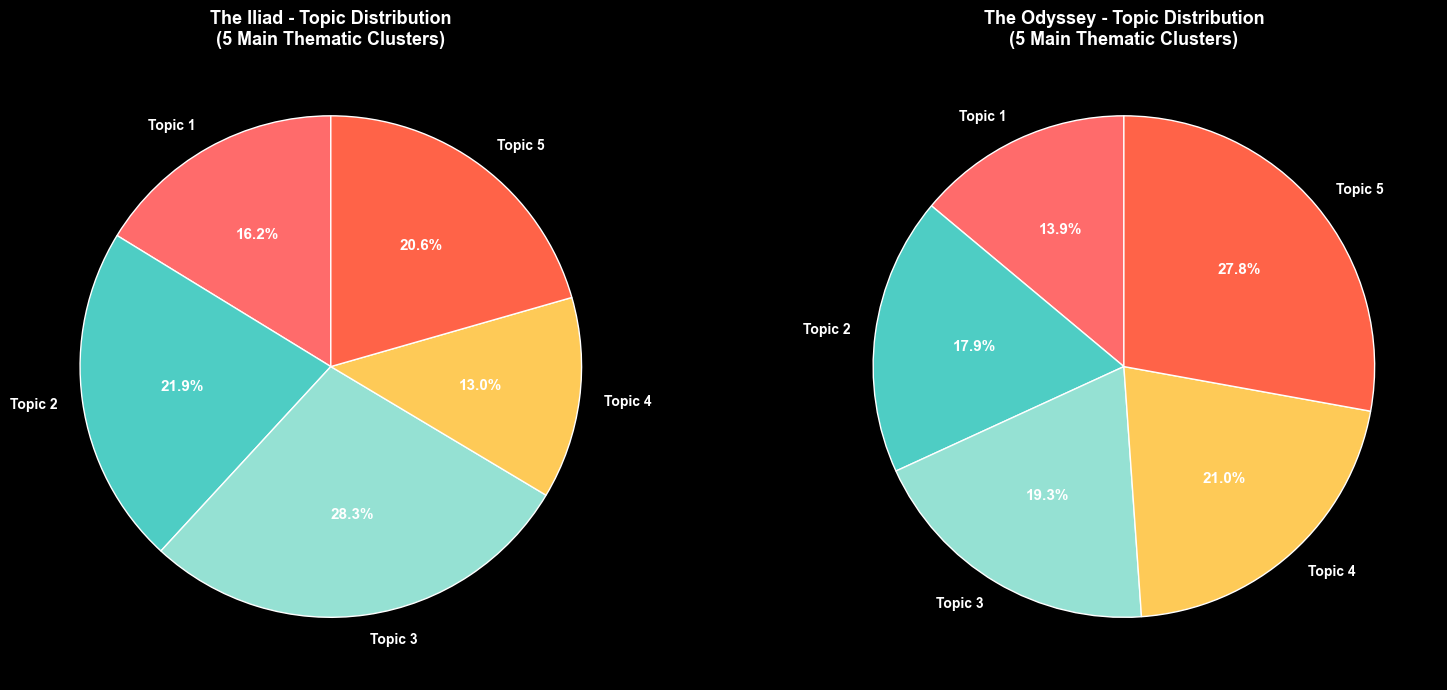


TOPIC DISTRIBUTION SUMMARY

The Iliad:
  Topic 1: 181 paragraphs (16.2%)
  Topic 2: 244 paragraphs (21.9%)
  Topic 3: 315 paragraphs (28.3%)
  Topic 4: 145 paragraphs (13.0%)
  Topic 5: 229 paragraphs (20.6%)

The Odyssey:
  Topic 1: 143 paragraphs (13.9%)
  Topic 2: 184 paragraphs (17.9%)
  Topic 3: 198 paragraphs (19.3%)
  Topic 4: 216 paragraphs (21.0%)
  Topic 5: 286 paragraphs (27.8%)

Note: Topics are identified by semantic similarity.
Manual inspection of sample paragraphs would reveal actual themes
(e.g., battle scenes, dialogue, divine intervention, travel, etc.)


In [37]:
from sklearn.cluster import KMeans

print("\n" + "="*70)
print("TOPIC DIVERSITY ANALYSIS")
print("="*70)

def cluster_paragraphs_by_topic(paragraphs: List[str], n_clusters: int = 5):
    """
    Use K-means clustering on paragraph embeddings to identify major themes.

    Each cluster represents a group of semantically similar paragraphs
    (e.g., battle scenes, dialogue, travel descriptions, etc.)

    Args:
        paragraphs: list of paragraph texts
        n_clusters: number of topic clusters to find

    Returns:
        Cluster labels for each paragraph
    """
    print(f"Clustering {len(paragraphs)} paragraphs into {n_clusters} topics...")

    # Get embeddings for all paragraphs (this may take a moment)
    para_embeddings = model.encode(paragraphs, show_progress_bar=True)

    # Use K-means to find clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(para_embeddings)

    print("✓ Clustering complete")
    return labels

# Cluster paragraphs into 5 main topics for each epic
print("\nAnalyzing The Iliad...")
iliad_clusters = cluster_paragraphs_by_topic(iliad_paras, n_clusters=5)

print("\nAnalyzing The Odyssey...")
odyssey_clusters = cluster_paragraphs_by_topic(odyssey_paras, n_clusters=5)

# Count paragraphs in each cluster
iliad_cluster_counts = [np.sum(iliad_clusters == i) for i in range(5)]
odyssey_cluster_counts = [np.sum(odyssey_clusters == i) for i in range(5)]

# Inspect topics by looking at sample paragraphs from each cluster
print("\n" + "="*70)
print("TOPIC INSPECTION - Sample paragraphs from each cluster")
print("="*70)

print("\n--- THE ILIAD TOPICS ---")
for i in range(5):
    print(f"\n{'='*70}")
    print(f"TOPIC {i+1} ({iliad_cluster_counts[i]} paragraphs, {iliad_cluster_counts[i]/len(iliad_paras)*100:.1f}%)")
    print(f"{'='*70}")
    # Get paragraphs in this cluster
    cluster_paras = [p for j, p in enumerate(iliad_paras) if iliad_clusters[j] == i]
    # Show first paragraph as example (truncated)
    sample = cluster_paras[0][:300] + "..." if len(cluster_paras[0]) > 300 else cluster_paras[0]
    print(f"Sample: {sample}\n")

print("\n--- THE ODYSSEY TOPICS ---")
for i in range(5):
    print(f"\n{'='*70}")
    print(f"TOPIC {i+1} ({odyssey_cluster_counts[i]} paragraphs, {odyssey_cluster_counts[i]/len(odyssey_paras)*100:.1f}%)")
    print(f"{'='*70}")
    # Get paragraphs in this cluster
    cluster_paras = [p for j, p in enumerate(odyssey_paras) if odyssey_clusters[j] == i]
    # Show first paragraph as example (truncated)
    sample = cluster_paras[0][:300] + "..." if len(cluster_paras[0]) > 300 else cluster_paras[0]
    print(f"Sample: {sample}\n")

print("\n" + "="*70)
print("MANUAL TOPIC LABELING")
print("="*70)
print("Based on the sample paragraphs above, manually assign labels:")
print("Examples: 'Battle Scenes', 'Dialogue', 'Divine Intervention',")
print("         'Journey/Travel', 'Character Descriptions', etc.")
print("\nUpdate the topic_labels list below with your labels:")

# MANUALLY UPDATE THESE LABELS based on what you see in the samples above
# After reading the sample paragraphs, replace these generic labels:
iliad_topic_labels = [
    'Topic 1',  # <-- Replace with actual theme (e.g., 'Battle Scenes')
    'Topic 2',  # <-- Replace with actual theme
    'Topic 3',  # <-- Replace with actual theme
    'Topic 4',  # <-- Replace with actual theme
    'Topic 5'   # <-- Replace with actual theme
]

odyssey_topic_labels = [
    'Topic 1',  # <-- Replace with actual theme (e.g., 'Sea Journey')
    'Topic 2',  # <-- Replace with actual theme
    'Topic 3',  # <-- Replace with actual theme
    'Topic 4',  # <-- Replace with actual theme
    'Topic 5'   # <-- Replace with actual theme
]

# Create pie charts with your custom labels
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

colors = ['#ff6b6b', '#4ecdc4', '#95e1d3', '#feca57', '#ff6348']

# The Iliad pie chart
wedges1, texts1, autotexts1 = ax1.pie(iliad_cluster_counts, labels=iliad_topic_labels,
                                        autopct='%1.1f%%', colors=colors, startangle=90,
                                        textprops={'fontsize': 10, 'fontweight': 'bold'})
# Make percentage text more visible
for autotext in autotexts1:
    autotext.set_color('white')
    autotext.set_fontsize(11)
ax1.set_title('The Iliad - Topic Distribution\n(5 Main Thematic Clusters)',
              fontsize=13, fontweight='bold')

# The Odyssey pie chart
wedges2, texts2, autotexts2 = ax2.pie(odyssey_cluster_counts, labels=odyssey_topic_labels,
                                        autopct='%1.1f%%', colors=colors, startangle=90,
                                        textprops={'fontsize': 10, 'fontweight': 'bold'})
# Make percentage text more visible
for autotext in autotexts2:
    autotext.set_color('white')
    autotext.set_fontsize(11)
ax2.set_title('The Odyssey - Topic Distribution\n(5 Main Thematic Clusters)',
              fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig("../results/paragraph_topic_clustering.png", dpi=300, bbox_inches='tight')
print("\n✓ Saved: ../results/paragraph_topic_clustering.png")
plt.show()

print("\n" + "="*70)
print("TOPIC DISTRIBUTION SUMMARY")
print("="*70)
print("\nThe Iliad:")
for i, count in enumerate(iliad_cluster_counts):
    print(f"  Topic {i+1}: {count} paragraphs ({count/len(iliad_paras)*100:.1f}%)")

print("\nThe Odyssey:")
for i, count in enumerate(odyssey_cluster_counts):
    print(f"  Topic {i+1}: {count} paragraphs ({count/len(odyssey_paras)*100:.1f}%)")

print("\nNote: Topics are identified by semantic similarity.")
print("Manual inspection of sample paragraphs would reveal actual themes")
print("(e.g., battle scenes, dialogue, divine intervention, travel, etc.)")



3D VISUALIZATION OF PARAGRAPH EMBEDDINGS
Encoding paragraphs for 3D visualization...


Batches: 100%|██████████| 16/16 [00:01<00:00, 12.27it/s]


Reducing dimensions to 3D...
✓ Explained variance: 15.3%
✓ Saved: ../results/paragraph_3d_analysis.png


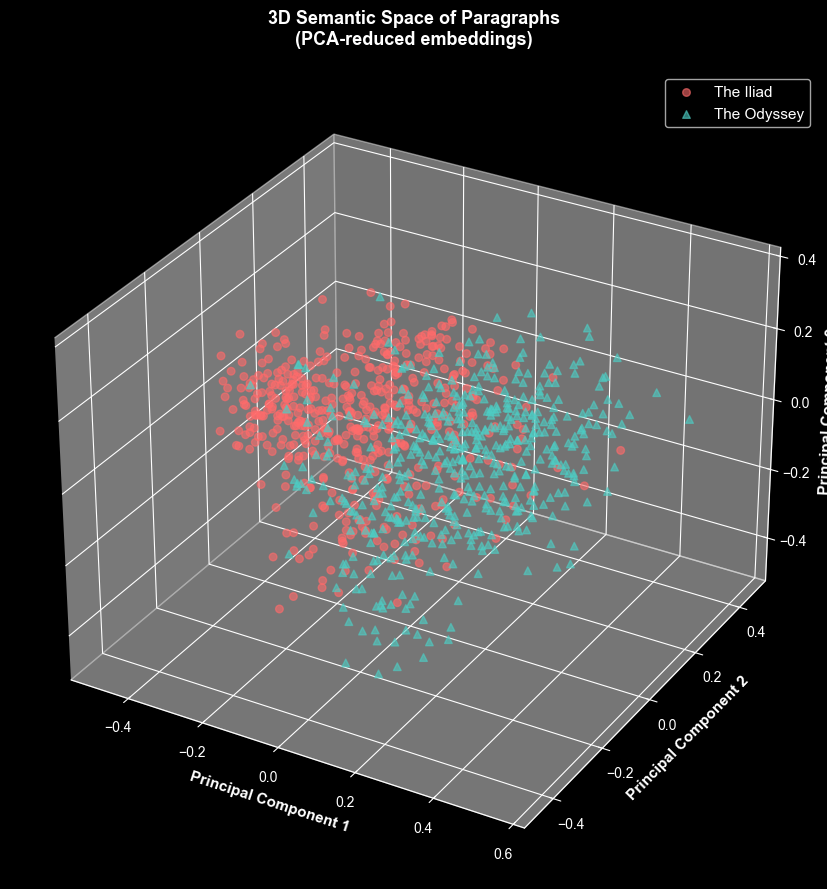


3D VISUALIZATION INTERPRETATION
What this shows:
- Each point represents one paragraph in semantic space
- Distance between points = semantic similarity
- Close points = similar topics/themes
- Clusters reveal thematic groupings
- Red circles = Iliad paragraphs
- Teal triangles = Odyssey paragraphs
- Overlap regions = shared themes between epics
- Separate regions = unique thematic content


In [38]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

print("\n" + "="*70)
print("3D VISUALIZATION OF PARAGRAPH EMBEDDINGS")
print("="*70)

# Get embeddings for both epics
print("Encoding paragraphs for 3D visualization...")
iliad_embeddings = model.encode(iliad_paras[:500], show_progress_bar=True)  # Limit for performance
odyssey_embeddings = model.encode(odyssey_paras[:500], show_progress_bar=True)

# Reduce high-dimensional embeddings to 3D using PCA
print("Reducing dimensions to 3D...")
all_embeddings = np.vstack([iliad_embeddings, odyssey_embeddings])
pca = PCA(n_components=3)
embeddings_3d = pca.fit_transform(all_embeddings)

# Split back into Iliad and Odyssey
iliad_3d = embeddings_3d[:len(iliad_embeddings)]
odyssey_3d = embeddings_3d[len(iliad_embeddings):]

print(f"✓ Explained variance: {sum(pca.explained_variance_ratio_)*100:.1f}%")

# Create 3D scatter plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Plot both epics
ax.scatter(iliad_3d[:, 0], iliad_3d[:, 1], iliad_3d[:, 2],
           c='#ff6b6b', marker='o', s=30, alpha=0.6, label='The Iliad')
ax.scatter(odyssey_3d[:, 0], odyssey_3d[:, 1], odyssey_3d[:, 2],
           c='#4ecdc4', marker='^', s=30, alpha=0.6, label='The Odyssey')

ax.set_xlabel('Principal Component 1', fontsize=11, fontweight='bold')
ax.set_ylabel('Principal Component 2', fontsize=11, fontweight='bold')
ax.set_zlabel('Principal Component 3', fontsize=11, fontweight='bold')
ax.set_title('3D Semantic Space of Paragraphs\n(PCA-reduced embeddings)',
             fontsize=13, fontweight='bold', pad=20)
ax.legend(fontsize=11)

plt.tight_layout()
plt.savefig("../results/paragraph_3d_analysis.png", dpi=300, bbox_inches='tight')
print("✓ Saved: ../results/paragraph_3d_analysis.png")
plt.show()

print("\n" + "="*70)
print("3D VISUALIZATION INTERPRETATION")
print("="*70)
print("What this shows:")
print("- Each point represents one paragraph in semantic space")
print("- Distance between points = semantic similarity")
print("- Close points = similar topics/themes")
print("- Clusters reveal thematic groupings")
print("- Red circles = Iliad paragraphs")
print("- Teal triangles = Odyssey paragraphs")
print("- Overlap regions = shared themes between epics")
print("- Separate regions = unique thematic content")


SEMANTIC SIMILARITY HEATMAP - Book-to-Book Comparison
  Found 24 books in The Iliad
  Encoding books...


Batches: 100%|██████████| 1/1 [00:00<00:00,  5.16it/s]

  Found 24 books in The Odyssey
  Encoding books...



Batches: 100%|██████████| 1/1 [00:00<00:00,  7.55it/s]



✓ Saved: ../results/book_similarity_heatmaps.png


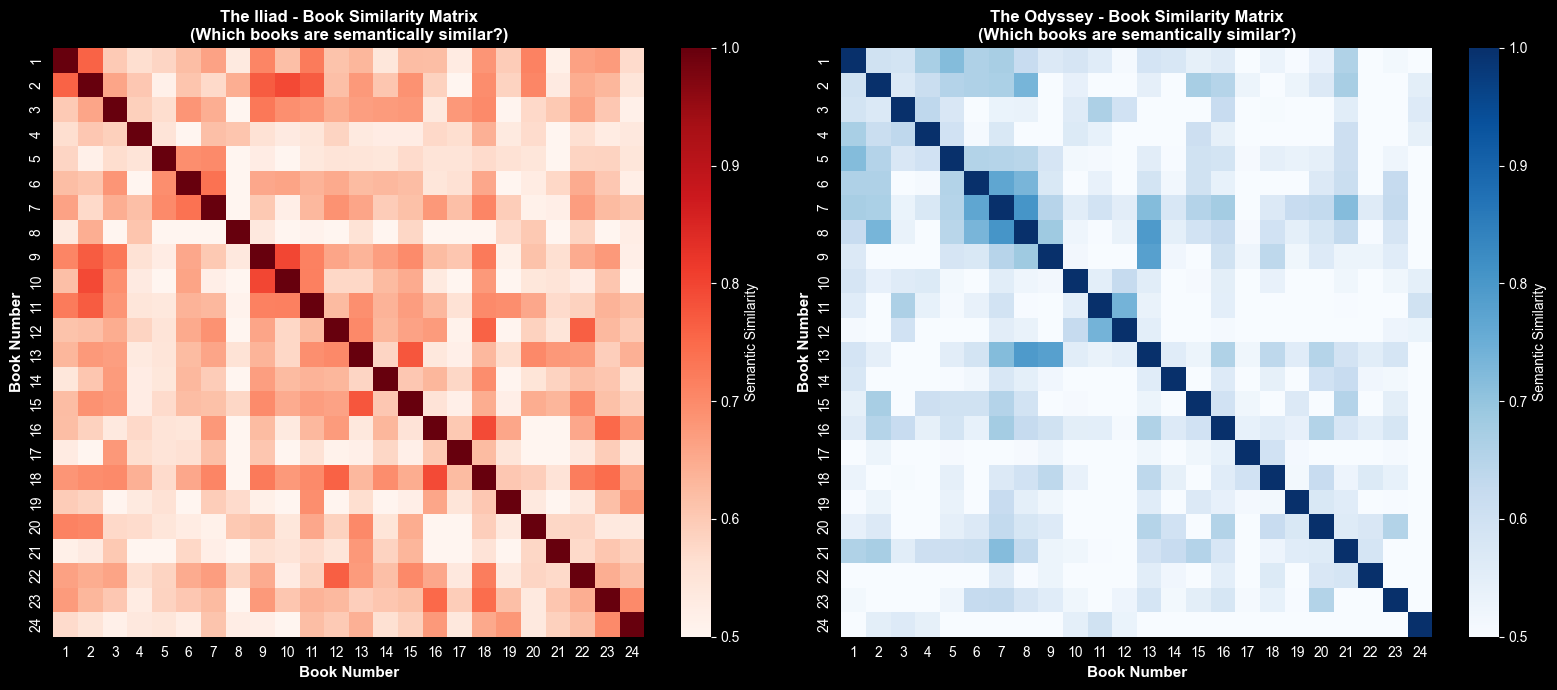


HEATMAP INTERPRETATION
What this shows:
- Darker/redder colors = more semantically similar books
- Diagonal is always dark (each book is identical to itself)
- Off-diagonal dark spots = books with similar themes/content
- Light areas = books with different themes
- Patterns reveal narrative structure:
  * Clustered dark regions = related narrative arcs
  * Uniform similarity = consistent style throughout
  * Variable similarity = episodic structure with distinct sections


In [39]:
from scipy.spatial.distance import cosine
import seaborn as sns

print("\n" + "="*70)
print("SEMANTIC SIMILARITY HEATMAP - Book-to-Book Comparison")
print("="*70)

def split_into_books_and_encode(text: str, epic_name: str):
    """
    Split epic into 24 books and get embedding for each book.

    Strategy: Combine all paragraphs in each book into one text,
    then encode to get a single embedding representing that book's content.
    """
    # Split into books using BOOK markers
    book_pattern = re.compile(r'BOOK\s+([IVXLCDM]+)', re.IGNORECASE)
    matches = list(book_pattern.finditer(text))

    if not matches:
        print(f"  Warning: No BOOK markers found in {epic_name}")
        return None

    books_text = []
    for i, match in enumerate(matches):
        start_pos = match.end()
        if i < len(matches) - 1:
            end_pos = matches[i + 1].start()
        else:
            end_pos = len(text)

        book_text = text[start_pos:end_pos].strip()
        if len(book_text) > 500:  # Only include substantial books
            books_text.append(book_text)

    print(f"  Found {len(books_text)} books in {epic_name}")
    print(f"  Encoding books...")

    # Get embedding for each book
    book_embeddings = model.encode(books_text, show_progress_bar=True)

    return book_embeddings

# Get book embeddings for both epics
iliad_book_embeds = split_into_books_and_encode(iliad_text, "The Iliad")
odyssey_book_embeds = split_into_books_and_encode(odyssey_text, "The Odyssey")

if iliad_book_embeds is not None and odyssey_book_embeds is not None:
    # Calculate similarity matrices (1 - cosine distance = cosine similarity)
    n_iliad_books = len(iliad_book_embeds)
    n_odyssey_books = len(odyssey_book_embeds)

    # Iliad similarity matrix
    iliad_sim_matrix = np.zeros((n_iliad_books, n_iliad_books))
    for i in range(n_iliad_books):
        for j in range(n_iliad_books):
            iliad_sim_matrix[i, j] = 1 - cosine(iliad_book_embeds[i], iliad_book_embeds[j])

    # Odyssey similarity matrix
    odyssey_sim_matrix = np.zeros((n_odyssey_books, n_odyssey_books))
    for i in range(n_odyssey_books):
        for j in range(n_odyssey_books):
            odyssey_sim_matrix[i, j] = 1 - cosine(odyssey_book_embeds[i], odyssey_book_embeds[j])

    # Create heatmaps
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

    # Iliad heatmap
    sns.heatmap(iliad_sim_matrix, annot=False, cmap='Reds',
                xticklabels=range(1, n_iliad_books+1),
                yticklabels=range(1, n_iliad_books+1),
                cbar_kws={'label': 'Semantic Similarity'},
                ax=ax1, vmin=0.5, vmax=1.0)
    ax1.set_title('The Iliad - Book Similarity Matrix\n(Which books are semantically similar?)',
                  fontsize=12, fontweight='bold')
    ax1.set_xlabel('Book Number', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Book Number', fontsize=11, fontweight='bold')

    # Odyssey heatmap
    sns.heatmap(odyssey_sim_matrix, annot=False, cmap='Blues',
                xticklabels=range(1, n_odyssey_books+1),
                yticklabels=range(1, n_odyssey_books+1),
                cbar_kws={'label': 'Semantic Similarity'},
                ax=ax2, vmin=0.5, vmax=1.0)
    ax2.set_title('The Odyssey - Book Similarity Matrix\n(Which books are semantically similar?)',
                  fontsize=12, fontweight='bold')
    ax2.set_xlabel('Book Number', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Book Number', fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.savefig("../results/book_similarity_heatmaps.png", dpi=300, bbox_inches='tight')
    print("\n✓ Saved: ../results/book_similarity_heatmaps.png")
    plt.show()

    print("\n" + "="*70)
    print("HEATMAP INTERPRETATION")
    print("="*70)
    print("What this shows:")
    print("- Darker/redder colors = more semantically similar books")
    print("- Diagonal is always dark (each book is identical to itself)")
    print("- Off-diagonal dark spots = books with similar themes/content")
    print("- Light areas = books with different themes")
    print("- Patterns reveal narrative structure:")
    print("  * Clustered dark regions = related narrative arcs")
    print("  * Uniform similarity = consistent style throughout")
    print("  * Variable similarity = episodic structure with distinct sections")


SEMANTIC DRIFT ANALYSIS - Tracking Language Evolution Across Books

The Iliad: Found 24 books
Encoding books for semantic analysis...


Batches: 100%|██████████| 1/1 [00:00<00:00,  6.34it/s]

Calculating drift metrics...

The Odyssey: Found 24 books
Encoding books for semantic analysis...



Batches: 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]


Calculating drift metrics...

✓ Saved: ../results/semantic_drift_analysis.png


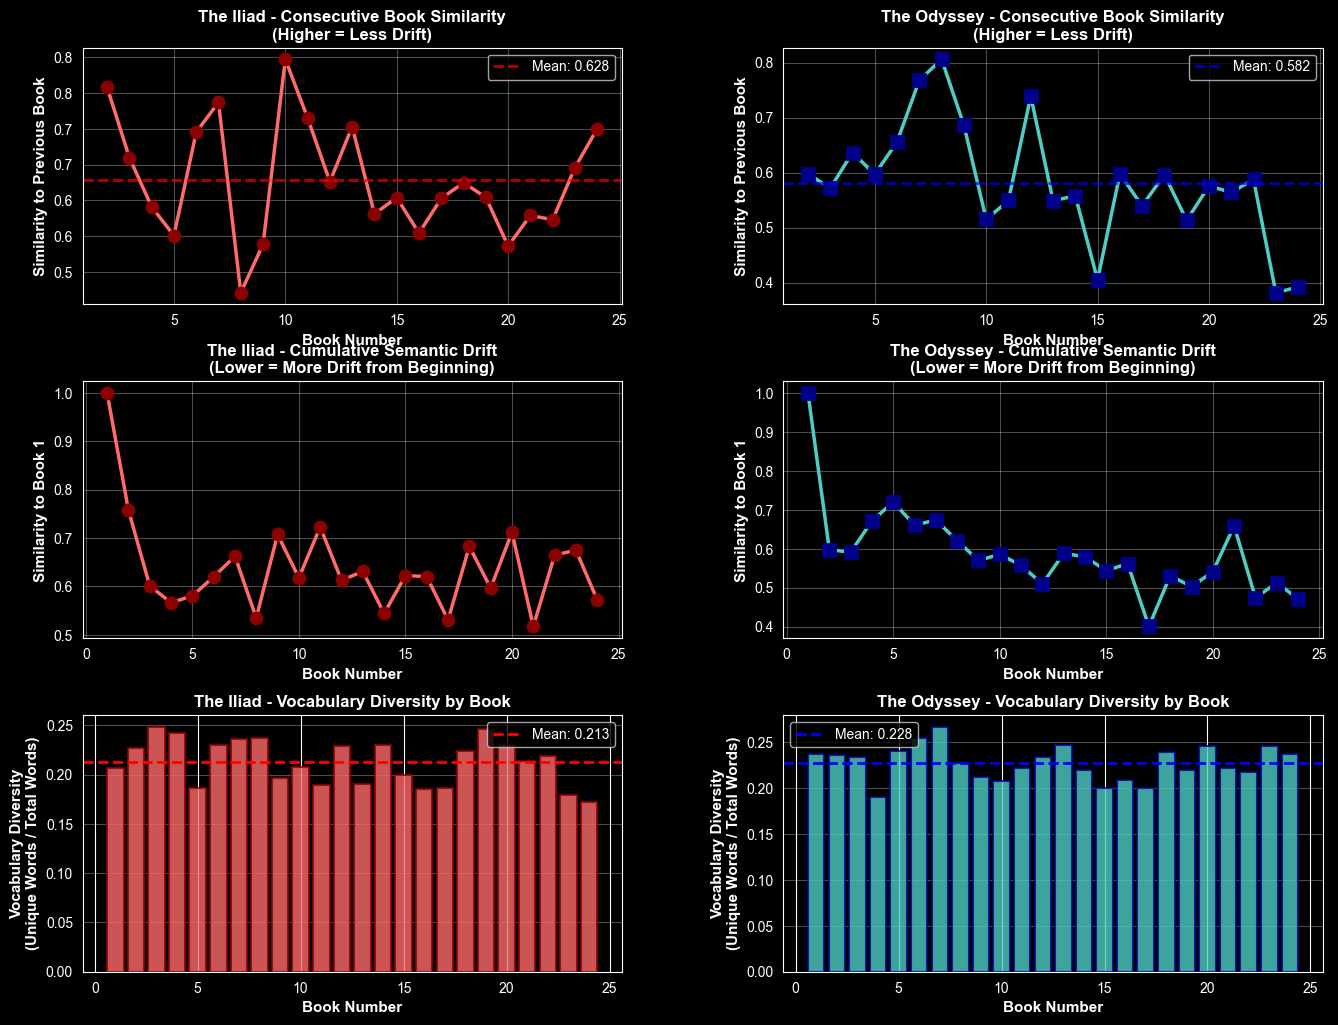


SEMANTIC DRIFT STATISTICS

The Iliad:
  Books analyzed: 24
  Average consecutive similarity: 0.6282
  Std dev of drift: 0.0793
  Max drift (lowest similarity): 0.4712 (Books 7-8)
  Final similarity to Book 1: 0.5721
  Average vocabulary diversity: 0.2130

The Odyssey:
  Books analyzed: 24
  Average consecutive similarity: 0.5819
  Std dev of drift: 0.1047
  Max drift (lowest similarity): 0.3816 (Books 22-23)
  Final similarity to Book 1: 0.4707
  Average vocabulary diversity: 0.2278

INTERPRETATION GUIDE

Consecutive Book Similarity:
  - Measures semantic change between adjacent books
  - Drops indicate narrative shifts or new themes
  - Stable = consistent language/themes

Cumulative Drift from Book 1:
  - Shows how much language has evolved from the opening
  - Downward trend = progressive semantic shift
  - Flat = narrative returns to original themes

Vocabulary Diversity:
  - Higher = more varied word choice
  - Lower = repetitive language (formulaic epic style)
  - Spikes may ind

In [40]:
print("\n" + "="*70)
print("SEMANTIC DRIFT ANALYSIS - Tracking Language Evolution Across Books")
print("="*70)

def analyze_semantic_drift(text: str, epic_name: str):
    """
    Analyze how language and vocabulary evolve across the 24 books.

    Tracks:
    1. Semantic similarity between consecutive books (drift)
    2. Vocabulary diversity per book
    3. Cumulative semantic change from Book 1
    4. Rate of semantic change over narrative arc

    Args:
        text: full epic text
        epic_name: name for display

    Returns:
        Dictionary with drift metrics
    """
    # Split into books
    book_pattern = re.compile(r'BOOK\s+([IVXLCDM]+)', re.IGNORECASE)
    matches = list(book_pattern.finditer(text))

    if not matches:
        print(f"  Error: No BOOK markers found in {epic_name}")
        return None

    books_text = []
    for i, match in enumerate(matches):
        start_pos = match.end()
        end_pos = matches[i + 1].start() if i < len(matches) - 1 else len(text)
        book_text = text[start_pos:end_pos].strip()
        if len(book_text) > 500:
            books_text.append(book_text)

    print(f"\n{epic_name}: Found {len(books_text)} books")
    print("Encoding books for semantic analysis...")

    # Get embeddings for each book
    book_embeddings = model.encode(books_text, show_progress_bar=True)

    # Calculate metrics
    consecutive_similarities = []
    cumulative_drift = []
    vocabulary_diversity = []

    print("Calculating drift metrics...")

    for i in range(len(books_text)):
        # Vocabulary diversity: unique words / total words
        words = re.findall(r'\b[a-z]+\b', books_text[i].lower())
        vocab_div = len(set(words)) / len(words) if words else 0
        vocabulary_diversity.append(vocab_div)

        # Consecutive book similarity
        if i > 0:
            sim = 1 - cosine(book_embeddings[i-1], book_embeddings[i])
            consecutive_similarities.append(sim)

        # Cumulative drift from Book 1
        drift_from_start = 1 - cosine(book_embeddings[0], book_embeddings[i])
        cumulative_drift.append(drift_from_start)

    return {
        'consecutive_similarities': consecutive_similarities,
        'cumulative_drift': cumulative_drift,
        'vocabulary_diversity': vocabulary_diversity,
        'n_books': len(books_text)
    }

# Analyze both epics
iliad_drift = analyze_semantic_drift(iliad_text, "The Iliad")
odyssey_drift = analyze_semantic_drift(odyssey_text, "The Odyssey")

# Create comprehensive visualization
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Plot 1: Consecutive Book Similarity (Iliad)
ax1 = fig.add_subplot(gs[0, 0])
book_transitions = list(range(2, iliad_drift['n_books'] + 1))
ax1.plot(book_transitions, iliad_drift['consecutive_similarities'],
         marker='o', linewidth=2.5, markersize=8, color='#ff6b6b',
         markerfacecolor='darkred', markeredgewidth=2, markeredgecolor='darkred')
ax1.axhline(y=np.mean(iliad_drift['consecutive_similarities']),
            color='red', linestyle='--', linewidth=2, alpha=0.7,
            label=f'Mean: {np.mean(iliad_drift["consecutive_similarities"]):.3f}')
ax1.set_xlabel('Book Number', fontsize=11, fontweight='bold')
ax1.set_ylabel('Similarity to Previous Book', fontsize=11, fontweight='bold')
ax1.set_title('The Iliad - Consecutive Book Similarity\n(Higher = Less Drift)',
              fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}'))

# Plot 2: Consecutive Book Similarity (Odyssey)
ax2 = fig.add_subplot(gs[0, 1])
book_transitions_od = list(range(2, odyssey_drift['n_books'] + 1))
ax2.plot(book_transitions_od, odyssey_drift['consecutive_similarities'],
         marker='s', linewidth=2.5, markersize=8, color='#4ecdc4',
         markerfacecolor='darkblue', markeredgewidth=2, markeredgecolor='darkblue')
ax2.axhline(y=np.mean(odyssey_drift['consecutive_similarities']),
            color='blue', linestyle='--', linewidth=2, alpha=0.7,
            label=f'Mean: {np.mean(odyssey_drift["consecutive_similarities"]):.3f}')
ax2.set_xlabel('Book Number', fontsize=11, fontweight='bold')
ax2.set_ylabel('Similarity to Previous Book', fontsize=11, fontweight='bold')
ax2.set_title('The Odyssey - Consecutive Book Similarity\n(Higher = Less Drift)',
              fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}'))

# Plot 3: Cumulative Drift from Book 1 (Iliad)
ax3 = fig.add_subplot(gs[1, 0])
all_books = list(range(1, iliad_drift['n_books'] + 1))
ax3.plot(all_books, iliad_drift['cumulative_drift'],
         marker='o', linewidth=2.5, markersize=8, color='#ff6b6b',
         markerfacecolor='darkred', markeredgewidth=2, markeredgecolor='darkred')
ax3.set_xlabel('Book Number', fontsize=11, fontweight='bold')
ax3.set_ylabel('Similarity to Book 1', fontsize=11, fontweight='bold')
ax3.set_title('The Iliad - Cumulative Semantic Drift\n(Lower = More Drift from Beginning)',
              fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Plot 4: Cumulative Drift from Book 1 (Odyssey)
ax4 = fig.add_subplot(gs[1, 1])
all_books_od = list(range(1, odyssey_drift['n_books'] + 1))
ax4.plot(all_books_od, odyssey_drift['cumulative_drift'],
         marker='s', linewidth=2.5, markersize=8, color='#4ecdc4',
         markerfacecolor='darkblue', markeredgewidth=2, markeredgecolor='darkblue')
ax4.set_xlabel('Book Number', fontsize=11, fontweight='bold')
ax4.set_ylabel('Similarity to Book 1', fontsize=11, fontweight='bold')
ax4.set_title('The Odyssey - Cumulative Semantic Drift\n(Lower = More Drift from Beginning)',
              fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

# Plot 5: Vocabulary Diversity (Iliad)
ax5 = fig.add_subplot(gs[2, 0])
ax5.bar(all_books, iliad_drift['vocabulary_diversity'],
        color='#ff6b6b', edgecolor='darkred', linewidth=1.5, alpha=0.8)
ax5.axhline(y=np.mean(iliad_drift['vocabulary_diversity']),
            color='red', linestyle='--', linewidth=2,
            label=f'Mean: {np.mean(iliad_drift["vocabulary_diversity"]):.3f}')
ax5.set_xlabel('Book Number', fontsize=11, fontweight='bold')
ax5.set_ylabel('Vocabulary Diversity\n(Unique Words / Total Words)', fontsize=11, fontweight='bold')
ax5.set_title('The Iliad - Vocabulary Diversity by Book',
              fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')
ax5.legend()

# Plot 6: Vocabulary Diversity (Odyssey)
ax6 = fig.add_subplot(gs[2, 1])
ax6.bar(all_books_od, odyssey_drift['vocabulary_diversity'],
        color='#4ecdc4', edgecolor='darkblue', linewidth=1.5, alpha=0.8)
ax6.axhline(y=np.mean(odyssey_drift['vocabulary_diversity']),
            color='blue', linestyle='--', linewidth=2,
            label=f'Mean: {np.mean(odyssey_drift["vocabulary_diversity"]):.3f}')
ax6.set_xlabel('Book Number', fontsize=11, fontweight='bold')
ax6.set_ylabel('Vocabulary Diversity\n(Unique Words / Total Words)', fontsize=11, fontweight='bold')
ax6.set_title('The Odyssey - Vocabulary Diversity by Book',
              fontsize=12, fontweight='bold')
ax6.grid(True, alpha=0.3, axis='y')
ax6.legend()

plt.savefig("../results/semantic_drift_analysis.png", dpi=300, bbox_inches='tight')
print("\n✓ Saved: ../results/semantic_drift_analysis.png")
plt.show()

# Print detailed statistics
print("\n" + "="*70)
print("SEMANTIC DRIFT STATISTICS")
print("="*70)

print(f"\nThe Iliad:")
print(f"  Books analyzed: {iliad_drift['n_books']}")
print(f"  Average consecutive similarity: {np.mean(iliad_drift['consecutive_similarities']):.4f}")
print(f"  Std dev of drift: {np.std(iliad_drift['consecutive_similarities']):.4f}")
print(f"  Max drift (lowest similarity): {min(iliad_drift['consecutive_similarities']):.4f} "
      f"(Books {iliad_drift['consecutive_similarities'].index(min(iliad_drift['consecutive_similarities']))+1}-"
      f"{iliad_drift['consecutive_similarities'].index(min(iliad_drift['consecutive_similarities']))+2})")
print(f"  Final similarity to Book 1: {iliad_drift['cumulative_drift'][-1]:.4f}")
print(f"  Average vocabulary diversity: {np.mean(iliad_drift['vocabulary_diversity']):.4f}")

print(f"\nThe Odyssey:")
print(f"  Books analyzed: {odyssey_drift['n_books']}")
print(f"  Average consecutive similarity: {np.mean(odyssey_drift['consecutive_similarities']):.4f}")
print(f"  Std dev of drift: {np.std(odyssey_drift['consecutive_similarities']):.4f}")
print(f"  Max drift (lowest similarity): {min(odyssey_drift['consecutive_similarities']):.4f} "
      f"(Books {odyssey_drift['consecutive_similarities'].index(min(odyssey_drift['consecutive_similarities']))+1}-"
      f"{odyssey_drift['consecutive_similarities'].index(min(odyssey_drift['consecutive_similarities']))+2})")
print(f"  Final similarity to Book 1: {odyssey_drift['cumulative_drift'][-1]:.4f}")
print(f"  Average vocabulary diversity: {np.mean(odyssey_drift['vocabulary_diversity']):.4f}")

print("\n" + "="*70)
print("INTERPRETATION GUIDE")
print("="*70)
print("\nConsecutive Book Similarity:")
print("  - Measures semantic change between adjacent books")
print("  - Drops indicate narrative shifts or new themes")
print("  - Stable = consistent language/themes")

print("\nCumulative Drift from Book 1:")
print("  - Shows how much language has evolved from the opening")
print("  - Downward trend = progressive semantic shift")
print("  - Flat = narrative returns to original themes")

print("\nVocabulary Diversity:")
print("  - Higher = more varied word choice")
print("  - Lower = repetitive language (formulaic epic style)")
print("  - Spikes may indicate special episodes (prophecies, catalogues)")

print("\nPotential Insights:")
print("  - Major plot shifts appear as similarity drops")
print("  - Flashbacks/returns may show increased similarity to earlier books")
print("  - Action vs. dialogue scenes may differ in vocabulary diversity")
print("  - Oral tradition features (epithets) create lower diversity")


## Memory Cleanup

If you're running low on memory, run this cell to free up RAM by deleting large variables and clearing the model cache.

In [41]:
# If you're running low on memory, uncomment and run this section

# import gc
#
# # Delete large variables to free memory
# del iliad_text, odyssey_text
# del iliad_paras, odyssey_paras
# del iliad_scores, iliad_lengths, odyssey_scores, odyssey_lengths
#
# # Clear matplotlib figures
# plt.close('all')
#
# # Unload the model from memory
# del model
#
# # Force garbage collection
# gc.collect()
#
# print("Memory cleaned! Large variables deleted and garbage collected.")